In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read data

In [2]:
train = pd.read_csv("../data/raw/mower_market_snapshot.csv", sep=";")
test = pd.read_csv("../data/raw/submission_set.csv", sep=";")

# Show first rows

In [3]:
print("train size:", train.shape, "! test size:", test.shape)

train size: (1399, 11) ! test size: (600, 9)


In [4]:
train.head()

,capacity,failure_rate,id,margin,price,prod_cost,product_type,quality,warranty,market_share,attractiveness
0,10.492623,0.042528,18377,633.766584,828.802103,195.03551928211797,auto-portee,Low,3ans,0.006360,0.650648
1,20.273730,0.037896,19363,731.576817,882.894916,151.31809934886763,auto-portee,Low,3 ans.,0.006840,0.699792
2,20.190457,0.039111,19641,741.218202,919.355522,178.13731921134948,auto-portee,Low,3_ans,0.006179,0.632129
3,27.220131,0.041303,18728,654.255635,817.085097,162.82946157588628,auto-portee,Low,3 anss,0.007925,0.810730
4,16.370911,0.037938,18722,703.094527,844.581465,141.48693796090603,auto-portee,Medium,3ans.,0.007406,0.757614


In [5]:
test.head()

,capacity,failure_rate,id,margin,price,prod_cost,product_type,quality,warranty
0,21.313064,0.037928,20049,613.061762,768.160605,155.098843,auto-portee,Medium,3 ans
1,25.797234,0.038664,19699,701.321608,865.727540,164.405932,auto-portee,Low,3 ans
2,14.314083,0.043118,19704,654.147498,807.374158,153.226660,auto-portee,Low,3 ans
3,29.754390,0.038551,20072,669.083239,866.573954,197.490715,auto-portee,Low,3 ans
4,24.915116,0.038829,20183,675.313221,859.205792,183.892571,auto-portee,Low,3 ans


# Check over each columns

## Warranty looks weird

In [6]:
train.warranty.unique()

array(['3ans', '3 ans.', '3_ans', '3 anss', '3ans.', '3 ans', '3_ans.',
       '3_anss', '3anss', '2 ans', '2 anss', '2anss', '2_ans', '2ans',
       '2_ans.', '2 ans.', '2_anss', '2ans.', '1 an', '1an', '1_an.',
       '1ans', '1an.', '1_ans', '1_an', '1 an.', '1 ans'], dtype=object)

In [7]:
import re

train["warranty"] = train["warranty"].apply(lambda x: re.sub("[^0-9]", "", x))
train["warranty"] = train["warranty"].astype(int)

## Prod_cost should be a float

In [8]:
list(train["prod_cost"].unique())

['195.03551928211797',
 '151.31809934886763',
 '178.13731921134948',
 '162.82946157588628',
 '141.48693796090603',
 '177.01288573033196',
 '173.26373572791334',
 '184.56014118975136',
 '170.14746134881673',
 '186.1262903279073',
 '148.41503918168814',
 '195.81946333014687',
 '170.99957332823436',
 '139.9698450224172',
 '164.85980921486097',
 '208.75289206129202',
 '167.18992276086493',
 '161.26365131854845',
 '184.97391331970988',
 '156.25068438864682',
 '158.91492725312412',
 '185.56823156025672',
 '184.94371512383591',
 '199.8793048937394',
 '161.1003672316781',
 '149.78979724770687',
 '144.6246131371376',
 '148.98982075813146',
 '167.1419253018245',
 '183.50646371242973',
 '162.24738769188284',
 '192.43158866163057',
 '210.98494137927483',
 '157.84556070034944',
 '162.06122034931462',
 '187.72517747975849',
 '154.37302869548267',
 '156.59559325014203',
 '162.35254312665342',
 '166.9972836639568',
 '140.2610402168683',
 '138.32693813663494',
 '206.7959162257041',
 '145.10773620187885

In [9]:
def clean_prod_cost(row):
    try:
        return float(row)
    except ValueError as _:
        return -1.0

In [10]:
train["prod_cost"] = train["prod_cost"].apply(lambda x: clean_prod_cost(x))

### We need to take only row which contains a positiv prod_cost

In [11]:
train = train[train["prod_cost"] > 0]

## Check Id

In [12]:
print("As we can see, id column is useless", len(train.id.unique()), "/", len(train), "rows")

As we can see, id column is useless 1330 / 1330 rows


## Feature engineering

In [13]:
low = train.price.describe()["50%"]
medium = train.price.describe()["75%"]
good = train.price.describe()["max"]

In [14]:
def build_profit(row):
    return (row["price"] - row["prod_cost"]) / row["price"]


def build_quality_price(row):
    if row["price"] >= medium and row["quality"] == "Hight":
        return "Hight"
    if row["price"] >= medium and row["quality"] == "Medium":
        return "Low"
    if row["price"] >= medium and row["quality"] == "Low":
        return "Low"
    
    if row["price"] < medium and row["price"] >= low and row["quality"] == "Hight":
        return "Hight"
    if row["price"] < medium and row["price"] >= low and row["quality"] == "Medium":
        return "Medium"
    if row["price"] < medium and row["price"] >= low and row["quality"] == "Low":
        return "Low"

    if row["price"] < low and row["quality"] == "Hight":
        return "Hight"
    if row["price"] < low and row["quality"] == "Medium":
        return "Hight"
    if row["price"] < low and row["quality"] == "Low":
        return "Medium"  

In [15]:
train["profit"] = train.apply(lambda x: build_profit(x), axis=1)
train["quality_price"] = train.apply(lambda x: build_quality_price(x), axis=1)

## We don't have a lot of possible value for product_type, & quality so, we can just use a one hot encoder

In [16]:
train = pd.concat([train, pd.get_dummies(train["product_type"], prefix="prod_type", drop_first=True)], axis=1)
train = train.drop("product_type", axis=1)
train = pd.concat([train, pd.get_dummies(train["quality"], prefix="quality", drop_first=True)], axis=1)
train = train.drop("quality", axis=1)
train = pd.concat([train, pd.get_dummies(train["quality_price"], prefix="quality_price", drop_first=True)], axis=1)
train = train.drop("quality_price", axis=1)

### Now all columns looks good

In [17]:
train.dtypes

capacity                float64
failure_rate            float64
id                        int64
margin                  float64
price                   float64
prod_cost               float64
warranty                  int32
market_share            float64
attractiveness          float64
profit                  float64
prod_type_electrique      uint8
prod_type_essence         uint8
quality_Low               uint8
quality_Medium            uint8
quality_price_Low         uint8
quality_price_Medium      uint8
dtype: object

In [18]:
train.describe()

,capacity,failure_rate,id,margin,price,prod_cost,warranty,market_share,attractiveness,profit,prod_type_electrique,prod_type_essence,quality_Low,quality_Medium,quality_price_Low,quality_price_Medium
count,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000,1330.000000
mean,47.622208,0.166274,18957.304511,186.133891,244.018130,57.884239,1.498496,0.002141,0.636438,0.800636,0.296992,0.602256,0.696241,0.209023,0.374436,0.442105
std,19.933097,0.073468,404.971241,190.494666,246.668906,60.346610,0.672191,0.001779,0.124263,0.070595,0.457105,0.489616,0.460053,0.406763,0.484159,0.496824
min,0.013884,0.028906,18259.000000,52.943989,62.855737,7.095443,1.000000,0.000564,0.297384,0.619800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.840060,0.095719,18606.250000,62.257830,73.259116,10.779788,1.000000,0.001135,0.548766,0.728305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.370335,0.199655,18956.000000,66.411687,77.963302,12.255099,1.000000,0.001405,0.641078,0.836865,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,61.868304,0.227943,19307.750000,265.447661,380.436817,114.211909,2.000000,0.002448,0.727568,0.853517,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,104.614865,0.302465,19657.000000,790.012898,964.973926,210.984941,3.000000,0.009314,0.952877,0.897748,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Check device which have a prod_cost > price

In [19]:
print("There are", len(train[train["prod_cost"] >= train["price"]]), "device selling at a loss")

There are 0 device selling at a loss


# Plot the distribution

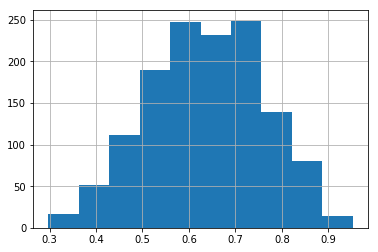

In [20]:
train.attractiveness.hist()

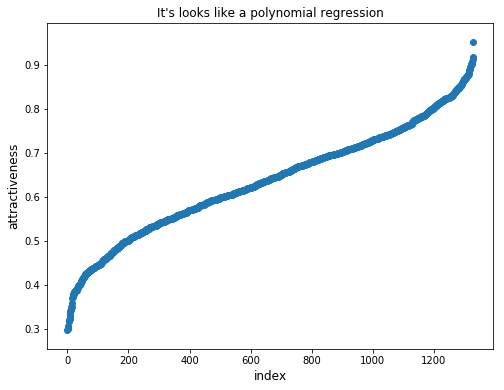

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(range(train.shape[0]), np.sort(train.attractiveness.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('attractiveness', fontsize=12)
plt.title("It's looks like a polynomial regression")
plt.show()

# Show correlation

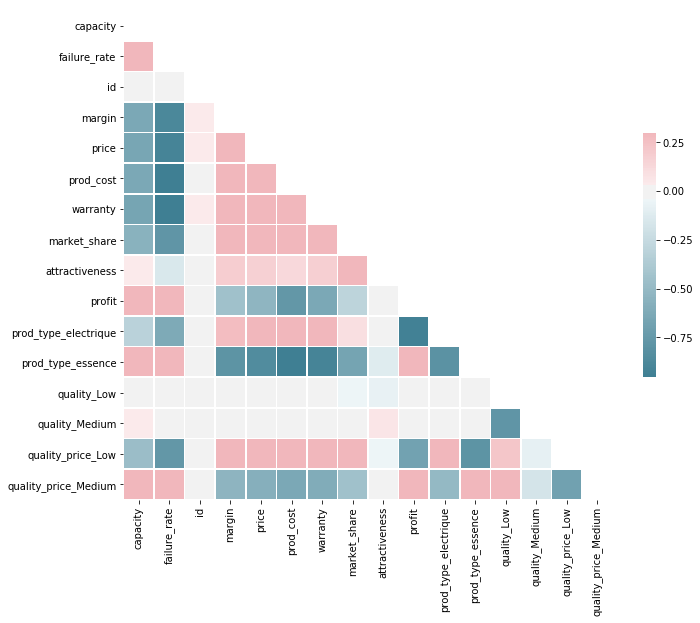

In [22]:
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(train.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

# As baseline I'll use a linear regression

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

import math

In [24]:
X = train.drop(["market_share", "attractiveness", "id"], axis=1)
y = train["attractiveness"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Check Multicolinearity (VIF)

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print("if the VIF value is > 5, there is Multicolinearity")
vif.round(3)

if the VIF value is > 5, there is Multicolinearity


,VIF Factor,features
0,1.774000,capacity
1,15.579000,failure_rate
2,inf,margin
3,inf,price
4,inf,prod_cost
5,2072.903000,warranty
6,37.986000,profit
7,201.977000,prod_type_electrique
8,1754.609000,prod_type_essence
9,8.582000,quality_Low


In [26]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [27]:
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)

    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [28]:
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficients":np.transpose(reg.coef_)}).sort_values(by="Coefficients")
print('Coefficients: \n', coefficients)
print("RMSLE: %.3f" % rmsle(y_test, y_pred))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.3f' % r2_score(y_test, y_pred))
print("Mean is", y.mean())
print("Here we are good compare to the mean")

Coefficients: 
     Coefficients               Feature
7      -0.337743  prod_type_electrique
8      -0.292214     prod_type_essence
6      -0.271928                profit
11     -0.165689     quality_price_Low
1      -0.152381          failure_rate
12     -0.051450  quality_price_Medium
3      -0.001810                 price
4      -0.001331             prod_cost
2      -0.000479                margin
0       0.001965              capacity
9       0.052074           quality_Low
10      0.056382        quality_Medium
5       0.922171              warranty
RMSLE: 0.066
RMSE: 0.106
Variance score: 0.308
Mean is 0.6364382104685304
Here we are good compare to the mean


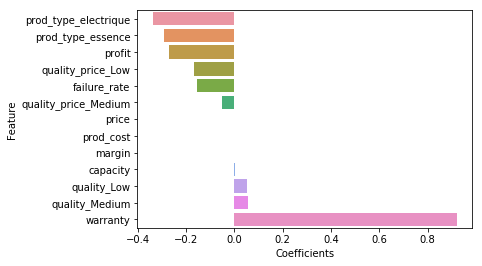

In [34]:
sns.barplot(y="Feature", x="Coefficients", data=coefficients)

## Plot the predict against real

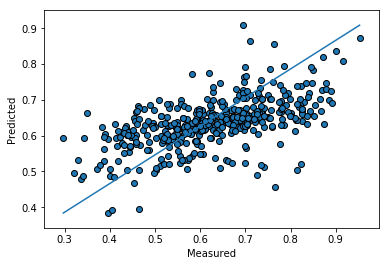

In [35]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

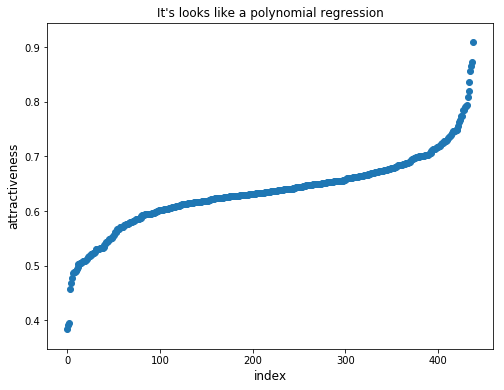

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred))
plt.xlabel('index', fontsize=12)
plt.ylabel('attractiveness', fontsize=12)
plt.title("It's looks like a polynomial regression")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023318899B38>]], dtype=object)

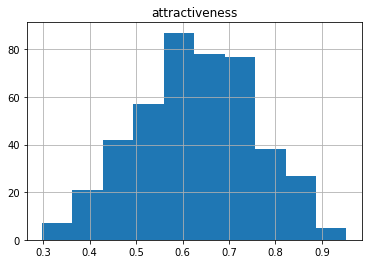

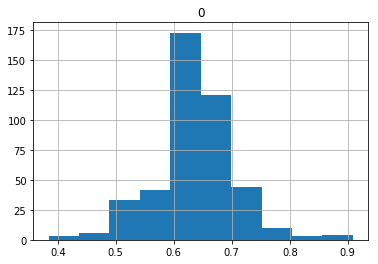

In [37]:
pd.DataFrame(y_test).hist()
pd.DataFrame(y_pred).hist()

# Apply polynomial regression

In [56]:
p = PolynomialFeatures(degree=2).fit(X)

In [57]:
print (p.get_feature_names(X.columns))

['1', 'capacity', 'failure_rate', 'margin', 'price', 'prod_cost', 'warranty', 'profit', 'prod_type_electrique', 'prod_type_essence', 'quality_Low', 'quality_Medium', 'quality_price_Low', 'quality_price_Medium', 'capacity^2', 'capacity failure_rate', 'capacity margin', 'capacity price', 'capacity prod_cost', 'capacity warranty', 'capacity profit', 'capacity prod_type_electrique', 'capacity prod_type_essence', 'capacity quality_Low', 'capacity quality_Medium', 'capacity quality_price_Low', 'capacity quality_price_Medium', 'failure_rate^2', 'failure_rate margin', 'failure_rate price', 'failure_rate prod_cost', 'failure_rate warranty', 'failure_rate profit', 'failure_rate prod_type_electrique', 'failure_rate prod_type_essence', 'failure_rate quality_Low', 'failure_rate quality_Medium', 'failure_rate quality_price_Low', 'failure_rate quality_price_Medium', 'margin^2', 'margin price', 'margin prod_cost', 'margin warranty', 'margin profit', 'margin prod_type_electrique', 'margin prod_type_ess

RMSLE: 0.045
RMSE: 0.073
Variance score: 0.662


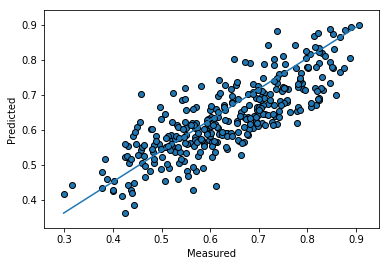

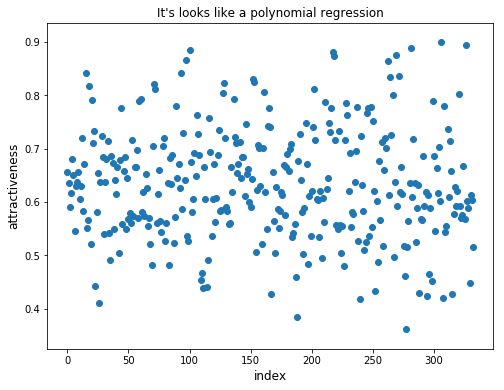

TypeError: only integer scalar arrays can be converted to a scalar index

In [48]:
from sklearn.preprocessing import PolynomialFeatures

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Apply Some Featuring
poly_reg = PolynomialFeatures(degree=2)

# Transform into numpy object
X_train = poly_reg.fit_transform(X_train)
X_test = poly_reg.fit_transform(X_test)
y_test = np.array(y_test)
y_train = np.array(y_train)

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("RMSLE: %.3f" % rmsle(y_test, y_pred))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.3f' % r2_score(y_test, y_pred))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred))
plt.xlabel('index', fontsize=12)
plt.ylabel('attractiveness', fontsize=12)
plt.title("It's looks like a polynomial regression")
plt.show()

# coefficients = pd.DataFrame({"Feature": list(range(X_train)), "Coefficients":np.transpose(reg.coef_)}).sort_values(by="Coefficients")
sns.barplot(y="Feature", x="Coefficients", data=coefficients)
plt.show()

pd.DataFrame(y_test).hist()
pd.DataFrame(y_pred).hist()

In [42]:
print("Here we are closer to the real one")

Here we are closer to the real one


# Now we may apply some features selection
## backward for example

In [51]:
print("I used a lasso, as features selection")

I used a lasso, as features selection


# So now, what's next ?
## Find the best model using the insights above

# Unique mdl

In [ ]:
train.drop(["id", "market_share"], axis=1).to_csv("train.csv", index=False)

Score on test set: 0.0565767280996
RMSLE: 0.044
RMSE: 0.071
Variance score: 0.664


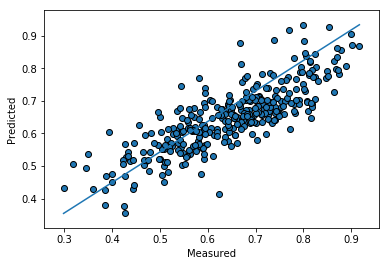

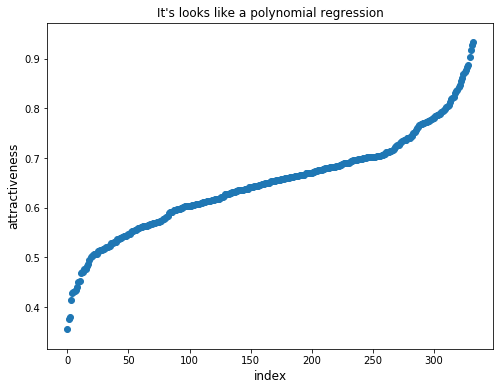

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002331DA10208>]], dtype=object)

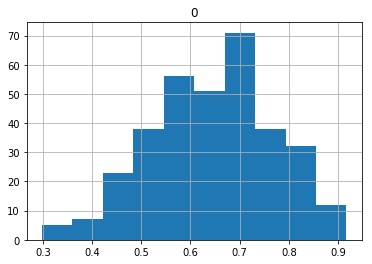

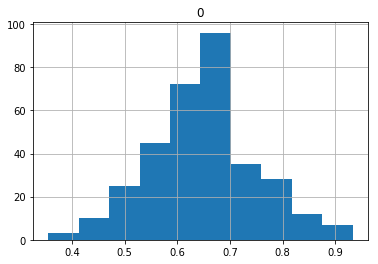

In [43]:
# -*- coding: utf-8 -*-
"""
Created on July 2017

@author: JulienWuthrich
"""
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model.least_angle import LassoLarsCV

from vecstack import stacking

# Read the csv file
data = pd.read_csv("train.csv")
regression = True

# Split dependants and independant variables
y = data[["attractiveness"]]
X = data.drop("attractiveness", axis=1)

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Apply Some Featuring
poly_reg = PolynomialFeatures(degree=2)

# Transform into numpy object
x_train = poly_reg.fit_transform(X_train)
X_test = poly_reg.fit_transform(X_test)
y_test = np.array(y_test.ix[:,0])
y_train = np.array(y_train.ix[:,0])

# Build model with good params
model = LassoLarsCV(copy_X=True, cv=None, eps=2.2204460492503131e-16,
      fit_intercept=True, max_iter=500, max_n_alphas=1000, n_jobs=1,
      normalize=False, positive=False, precompute='auto', verbose=False)

# Fit the model
model.fit(x_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Scoring
if regression:
    print('Score on test set:', mean_absolute_error(y_test, y_pred))
else:
    print('Score on test set:', accuracy_score(y_test, y_pred))

    
print("RMSLE: %.3f" % rmsle(y_test, y_pred))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.3f' % r2_score(y_test, y_pred))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred))
plt.xlabel('index', fontsize=12)
plt.ylabel('attractiveness', fontsize=12)
plt.title("It's looks like a polynomial regression")
plt.show()

sns.barplot(y="Feature", x="Coefficients", data=coefficients)
plt.show()

pd.DataFrame(y_test).hist()
pd.DataFrame(y_pred).hist()

# Stacked mdl

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on July 2017

@author: JulienWuthrich
"""
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, accuracy_score, r2_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNetCV, LassoLarsCV, RidgeCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from vecstack import stacking

# Read the csv file
data = pd.read_csv("train.csv")
regression = True
if regression:
    metric = r2_score
else:
    metric = accuracy_score

# Split dependants and independant variables
y = data[["attractiveness"]]
X = data.drop("attractiveness", axis=1)

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Apply Some Featuring
poly_reg = PolynomialFeatures(degree=2)

# Transform into numpy object
x_train = poly_reg.fit_transform(X_train)
x_test = poly_reg.fit_transform(X_test)
y_test = np.array(y_test.ix[:,0])
y_train = np.array(y_train.ix[:,0])

# define lmodels
lmodels = [ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features=0.9, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=3, min_samples_split=6,
          min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False), GradientBoostingRegressor(alpha=0.8, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=6, max_features=0.6,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=6,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=75, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False), ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.7, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.5, verbose=0)]

# build the stack level 1
S_train, S_test = stacking(
    lmodels, x_train, y_train, x_test,
    regression=regression, metric=rmsle,
    n_folds=3, shuffle=True, verbose=1
)

# build model lvel 2
model = ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.7, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.5, verbose=0)

# Fit the model
model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)

# Scoring
if regression:
    print('Score on test set:', mean_absolute_error(y_test, y_pred))
else:
    print('Score on test set:', accuracy_score(y_test, y_pred))

print("RMSLE: %.3f" % rmsle(y_test, y_pred))
print("RMSE: %.3f" % math.sqrt(mean_squared_error(y_test, y_pred)))
print('Variance score: %.3f' % r2_score(y_test, y_pred))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(range(y_pred.shape[0]), np.sort(y_pred))
plt.xlabel('index', fontsize=12)
plt.ylabel('attractiveness', fontsize=12)
plt.title("It's looks like a polynomial regression")
plt.show()

pd.DataFrame(y_test).hist()
pd.DataFrame(y_pred).hist()